In [1]:
!pip install torchaudio -q --no-deps
!pip install speechbrain -q
!pip install spectralcluster -q
!pip install pyannote.metrics -q
!pip install gdown -q

     |████████████████████████████████| 1.9MB 4.1MB/s 
     |████████████████████████████████| 358kB 4.2MB/s 
     |████████████████████████████████| 1.2MB 31.6MB/s 
     |████████████████████████████████| 645kB 41.4MB/s 
     |████████████████████████████████| 102kB 9.3MB/s 
     |████████████████████████████████| 552kB 42.5MB/s 
     |████████████████████████████████| 51kB 2.6MB/s 
     |████████████████████████████████| 51kB 3.2MB/s 
     |████████████████████████████████| 61kB 6.0MB/s 
     |████████████████████████████████| 133kB 25.7MB/s 


In [2]:
!gdown --id 1rUDuxPTqMMj-lH7Y9W14BgTxkyiVTntX
!unzip core.zip

Downloading...
From: https://drive.google.com/uc?id=1rUDuxPTqMMj-lH7Y9W14BgTxkyiVTntX
To: /content/core.zip
100% 14.9k/14.9k [00:00<00:00, 29.8MB/s]
Archive:  core.zip
   creating: core/
  inflating: core/baselineMethods.py  
  inflating: core/colab_demo_utils.py  
  inflating: core/DEC.py             
  inflating: core/optimumSpeaker.py  
  inflating: core/utils.py           
 extracting: core/__init__.py        


In [4]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
import torchaudio
import os
import torch
from torch.utils.data import Dataset, DataLoader
from speechbrain.pretrained import SpeakerRecognition
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans, SpectralClustering
from sklearn import decomposition
from tqdm.auto import tqdm

from core.utils import make_rttm, get_metrics
from core.utils import DiarizationDataSet
import core.baselineMethods as baselineMethods

import shutil
import pandas as pd

from core.DEC import ResidualAutoEncoder

In [5]:
import numpy as np
import torch
import torch.nn as nn
from sklearn.cluster import KMeans
from tqdm import tqdm
from scipy.optimize import linear_sum_assignment
from collections import OrderedDict
from tqdm.auto import tqdm

import torch.nn.functional as F
import torch.optim as optim

device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
# Test AutoEncoder
ae = ResidualAutoEncoder(192)
z, xo, xr = ae(torch.Tensor(np.zeros((10, 192))))
ae

ResidualAutoEncoder(
  (en1): Linear(in_features=192, out_features=500, bias=True)
  (en2): Linear(in_features=500, out_features=500, bias=True)
  (en3): Linear(in_features=500, out_features=2000, bias=True)
  (en4): Linear(in_features=2000, out_features=30, bias=True)
  (dc1): Linear(in_features=30, out_features=2000, bias=True)
  (dc2): Linear(in_features=2000, out_features=500, bias=True)
  (dc3): Linear(in_features=500, out_features=500, bias=True)
  (dc4): Linear(in_features=500, out_features=192, bias=True)
)

In [7]:
audio_dataset = DiarizationDataSet(dataset_name='voxconverse',
                                   window_len=1500, 
                                   window_step=250,
                                   split='train',
                                   use_oracle_vad=False,
                                   skip_overlap=False)

print("\nData size:", len(audio_dataset))

Downloading...
From: https://drive.google.com/uc?id=1-Ft9RKdEv6xcR3XHlVAgMNuf0jfy08aY
To: /content/tmp.zip
1.99GB [00:12, 163MB/s] 


Download and Extraction Complete


Downloading...
From: https://drive.google.com/uc?id=18oXqn9Zyt5tJpoEwKKztpTag-AJMQ2Sz
To: /content/tmp.zip
100%|██████████| 128k/128k [00:00<00:00, 50.5MB/s]


Download and Extraction Complete
Precomputed X-vectors exists!
Will use precomputed features...



Downloading...
From: https://drive.google.com/uc?id=1-21RPeA2KoAymyoa99qD7jvFk6A8bgu8
To: /content/tmp.zip
208MB [00:01, 199MB/s]


Download and Extraction Complete

Data size: 166


In [12]:
aeDataset = []
for i in range(len(audio_dataset)):
    data, diarization_segments, speech_segments, rttm_path = audio_dataset[i]
    data = data[speech_segments==1]
    aeDataset.append(data.detach().clone())

aeDataset =  torch.vstack(aeDataset)
aeDataset.shape

torch.Size([220389, 192])

In [ ]:
class StackAETrainer:
    def __init__(self, model, lr=0.0001):
        self.model = model
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)

    def train(self, epochs, dataset, lossType='local', batch_size=256):
        print('Training StackAE...')
        
        train_losses = []
        for epoch in range(epochs):
            dataset = dataset[np.random.choice(len(dataset), len(dataset), replace=False)]
            epochProgress = tqdm(range(len(dataset)//batch_size), leave=True, ncols=750)
            running_loss = 0.0
            num_examples = 0

            for data_idx in epochProgress:
                x_data = dataset[data_idx*batch_size:(data_idx+1)*batch_size]
                x_data = x_data.to(device)
                
                self.optimizer.zero_grad()
                
                z, xo, xr = self.model(x_data)
                
                if lossType=='local':
                    loss = (len(xo)-0)*self.criterion(xo[0], xr[0])
                    for i in range(1, len(xo)):
                        loss += (len(xo)-i)*self.criterion(xo[i], xr[i])

                    loss = loss/(len(xo)*(len(xo)+1)/2)
                    
                else:
                    loss = self.criterion(xo[0], xr[0])
                    
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item()
                num_examples += 1

                epochProgress.set_description("Epoch " + str(epoch+1) + "/" + str(epochs) + \
                                              " - train_loss: " + \
                                              str(round(running_loss/num_examples, 3)), \
                                              refresh=True)
                
            currloss = round(running_loss/num_examples, 3)
            train_losses.append(currloss)
            
        return train_losses

In [ ]:
ae = ResidualAutoEncoder(192)
ae = ae.to(device)

model = StackAETrainer(ae, lr=1e-3)
history = model.train(60, aeDataset)

Training StackAE...


  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

In [ ]:
model = StackAETrainer(ae, lr=1e-4)
history += model.train(60, aeDataset)

Training StackAE...


  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

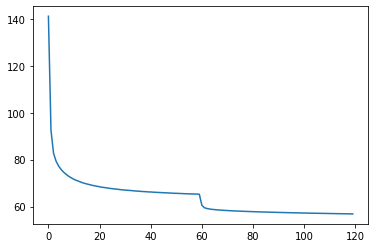

In [ ]:
plt.plot(history)

In [ ]:
# Save model
checkpoint = {'state_dict': model.model.state_dict()}
torch.save(checkpoint, './ResAE_Model_III.pth')

In [ ]:
tmp = torch.load('./ResAE_Model_III.pth')
ae = ResidualAutoEncoder(192)
ae.load_state_dict(tmp['state_dict'])
ae = ae.to(device)

model = StackAETrainer(ae, lr=1e-4)
history = model.train(120, aeDataset, lossType="recons")

Training StackAE...


  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

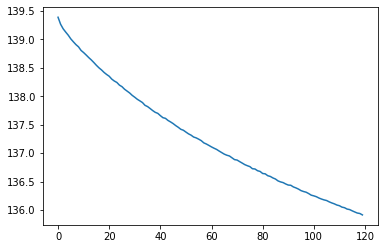

In [ ]:
plt.plot(history)

In [ ]:
# Save model
checkpoint = {'state_dict': model.model.state_dict()}
torch.save(checkpoint, './ResAE_Model_III_FT.pth')